In [3]:
pip install requests networkx


Note: you may need to restart the kernel to use updated packages.


# B∆∞·ªõc 1: Chu·∫©n b·ªã m√¥i tr∆∞·ªùng & API key

In [4]:
import json
import pandas as pd
import re
import os
from pathlib import Path
import time
import hashlib
from itertools import islice
import requests
import networkx as nx
from dotenv import load_dotenv
import  random
from itertools import islice
import networkx as nx



In [5]:
# Load API key
load_dotenv()
API_KEY = os.getenv("STEAM_API_KEY")
if not API_KEY:
    raise SystemExit("Please set STEAM_API_KEY in environment or .env file")

BASE = "https://api.steampowered.com"
CACHE_DIR = Path("steam_cache")
CACHE_DIR.mkdir(exist_ok=True)

DELAY_BETWEEN_REQUESTS = 0.5
BATCH_SIZE = 50
MAX_ACHIEVEMENTS_APPS = 3
REQUEST_TIMEOUT = 15


# STEAM CRAWLER - full functions (cache, API, endpoints, BFS crawler, save outputs)
- Cache ƒë·ªÉ tr√°nh request tr√πng
- API request v·ªõi backoff, skip private
- C√°c endpoint Steam: summaries, friends, owned games, recently played, groups, bans, achievements
- BFS crawl nhi·ªÅu batch, skip user/private, merge cu·ªëi c√πng
- Safe v·ªõi NetworkX GEXF (lo·∫°i b·ªè NoneType)

In [6]:
# %% 
"""
STEAM CRAWLER - SAFE THROTTLED + CHECKPOINT
--------------------------------------------
- Cache tr√°nh request tr√πng
- API request v·ªõi backoff & throttle
- BFS crawl nhi·ªÅu batch
- L∆∞u checkpoint m·ªói N user
- In progress ƒë·ªÉ theo d√µi ti·∫øn tr√¨nh
"""

# ================================
# Cache utils
# ================================
CACHE_DIR = Path("steam_cache")
CACHE_DIR.mkdir(exist_ok=True)

def cache_key(endpoint, params):
    s = endpoint + json.dumps(params, sort_keys=True)
    return hashlib.sha1(s.encode("utf-8")).hexdigest()

def cache_load(endpoint, params):
    k = cache_key(endpoint, params)
    p = CACHE_DIR / f"{k}.json"
    if p.exists():
        try:
            return json.loads(p.read_text(encoding="utf-8"))
        except Exception:
            return None
    return None

def cache_save(endpoint, params, data):
    k = cache_key(endpoint, params)
    p = CACHE_DIR / f"{k}.json"
    p.write_text(json.dumps(data, ensure_ascii=False, indent=2), encoding="utf-8")

# ================================
# Config crawl
# ================================
DELAY_MIN = 1.0
DELAY_MAX = 2.0
BATCH_SIZE = 50
MAX_APPS_PER_USER = 3
REQUEST_TIMEOUT = 15
CHECKPOINT_EVERY = 50
BASE = "https://api.steampowered.com"
API_KEY = os.getenv("STEAM_API_KEY")

# ================================
# API request with backoff & throttle
# ================================
def api_get(endpoint, params, use_cache=True):
    params = dict(params)
    params["key"] = API_KEY
    if use_cache:
        cached = cache_load(endpoint, params)
        if cached is not None:
            return cached

    url = f"{BASE}/{endpoint}"
    backoff = 1.0
    for attempt in range(6):
        try:
            r = requests.get(url, params=params, timeout=REQUEST_TIMEOUT)
            if r.status_code == 200:
                try: data = r.json()
                except ValueError: data = r.text
                cache_save(endpoint, params, data)
                time.sleep(random.uniform(DELAY_MIN, DELAY_MAX))
                return data
            elif r.status_code in (429, 503):
                time.sleep(backoff + random.uniform(0.1,0.5))
                backoff *= 2
            elif r.status_code in (401,403):
                print(f"[PRIVATE] skip: {params}")
                return {"private": True}
            else:
                print(f"[WARN] {r.status_code} from {url} params={params}")
                return None
        except requests.RequestException as e:
            print(f"[WARN] Request exception {e}, backoff {backoff}s")
            time.sleep(backoff + random.uniform(0.1,0.5))
            backoff *= 2
    print("[ERROR] Max retries exceeded for", url)
    return None


# Helper chunks
def chunks(iterable, n):
    it = iter(iterable)
    while True:
        chunk = list(islice(it, n))
        if not chunk: break
        yield chunk


# Steam endpoints
def get_player_summaries(steamid_list):
    endpoint="ISteamUser/GetPlayerSummaries/v0002/"; results=[]
    for batch in chunks(steamid_list,BATCH_SIZE):
        params={"steamids":",".join(batch)}
        data=api_get(endpoint,params)
        if data and not data.get("private"):
            results.extend(data.get("response",{}).get("players",[]))
    return results

def get_friend_list(steamid):
    endpoint="ISteamUser/GetFriendList/v0001/"
    params={"steamid":steamid,"relationship":"friend"}
    data=api_get(endpoint,params)
    if data and data.get("private"): return []
    return [f.get("steamid") for f in data.get("friendslist",{}).get("friends",[])] if data else []

def get_owned_games(steamid):
    endpoint="IPlayerService/GetOwnedGames/v0001/"
    params={"steamid":steamid,"include_appinfo":1,"include_played_free_games":1,"format":"json"}
    data=api_get(endpoint,params)
    if data and data.get("private"): return {}
    return data.get("response",{}) if data else {}

def get_recently_played(steamid):
    endpoint="IPlayerService/GetRecentlyPlayedGames/v0001/"
    params={"steamid":steamid}
    data=api_get(endpoint,params)
    if data and data.get("private"): return {}
    return data.get("response",{}) if data else {}

def get_user_groups(steamid):
    endpoint="ISteamUser/GetUserGroupList/v1/"
    params={"steamid":steamid}
    data=api_get(endpoint,params)
    if data and data.get("private"): return []
    return data.get("response",{}).get("groups",[]) if data else []

def get_player_bans(steamid_list):
    endpoint="ISteamUser/GetPlayerBans/v1/"; results=[]
    for batch in chunks(steamid_list,BATCH_SIZE):
        params={"steamids":",".join(batch)}
        data=api_get(endpoint,params)
        if data and not data.get("private"): results.extend(data.get("players",[]))
    return results

def get_player_achievements(steamid,appid):
    endpoint="ISteamUserStats/GetPlayerAchievements/v1/"
    params={"steamid":steamid,"appid":appid}
    data=api_get(endpoint,params)
    if data and data.get("private"): return {}
    return data.get("playerstats",{}) if data else {}

def resolve_vanity(name):
    endpoint="ISteamUser/ResolveVanityURL/v0001/"
    params={"vanityurl":name}
    data=api_get(endpoint,params)
    if data and data.get("response",{}).get("success")==1:
        return data["response"].get("steamid")
    return None

# Load existing profiles
def load_existing_profiles(json_path):
    if Path(json_path).exists():
        with open(json_path,"r",encoding="utf-8") as f:
            data=json.load(f)
        return set(data.keys()), data
    return set(), {}

# Save outputs
def save_outputs(G, profiles, out_prefix="steam_output"):
    # Clean node attributes
    for n, data in G.nodes(data=True):
        for k, v in list(data.items()):
            if v is None: data[k] = ""
            elif isinstance(v,(list,dict)): data[k]=str(v)
    json_path=f"{out_prefix}_profiles1.json"
    with open(json_path,"w",encoding="utf-8") as f: json.dump(profiles,f,indent=2,ensure_ascii=False)
    gexf_path=f"{out_prefix}_graph1.gexf"
    nx.write_gexf(G,gexf_path)
    print(f"[Saved] profiles -> {json_path}")
    print(f"[Saved] graph -> {gexf_path}")


# BFS crawler with checkpoint
def crawl(seed_ids, depth=1, max_users=1000, max_apps_per_user=3, visited_global=None, save_prefix="steam_output", fetch_achievements=True):
    G = nx.Graph()
    visited_global = visited_global or set()
    queue = [(s,0) for s in seed_ids]
    all_profiles = {}
    stats = {"public":0,"private":0,"skipped":0}

    while queue and len(visited_global)<max_users:
        steamid, d = queue.pop(0)
        if steamid in visited_global or d>depth: continue
        if not steamid.isdigit(): steamid=resolve_vanity(steamid) or steamid
        if not steamid.isdigit(): stats["skipped"]+=1; continue

        print(f"Crawling {steamid} (depth {d}) | Visited {len(visited_global)}/{max_users}")

        players = get_player_summaries([steamid])
        if not players:
            stats["private"]+=1
            visited_global.add(steamid)
            continue

        player = players[0]
        visited_global.add(steamid)
        stats["public"]+=1
        all_profiles[steamid] = player

        G.add_node(steamid,label=player.get("personaname",""),
                   avatar=player.get("avatarfull",""),
                   country=player.get("loccountrycode",""))

        friends = get_friend_list(steamid)
        for f in friends:
            G.add_edge(steamid,f)
            if f not in visited_global and d+1<=depth:
                queue.append((f,d+1))

        owned = get_owned_games(steamid)
        recent = get_recently_played(steamid)
        groups = get_user_groups(steamid)

        G.nodes[steamid]["owned_game_count"] = owned.get("game_count",0)
        G.nodes[steamid]["recent_count"] = recent.get("total_count",0)
        G.nodes[steamid]["groups"] = [g.get("groupid64") for g in groups] if groups else []

        apps = owned.get("games",[]) if isinstance(owned,dict) else []
        top_apps = sorted(apps, key=lambda x:x.get("playtime_forever",0), reverse=True)[:max_apps_per_user]
        G.nodes[steamid]["top_apps"] = [a.get("appid") for a in top_apps]

        # Achievements (optional, t·ªën th·ªùi gian)
        if fetch_achievements:
            achievements={}
            for app in top_apps: achievements[app.get("appid")] = get_player_achievements(steamid, app.get("appid"))
            G.nodes[steamid]["achievements_sample"] = achievements

        # Checkpoint every N users
        if len(visited_global) % CHECKPOINT_EVERY == 0:
            save_outputs(G, all_profiles, out_prefix=f"{save_prefix}_partial")
            print(f"[Checkpoint] Saved after {len(visited_global)} users")

    # Final bans
    bans = get_player_bans(list(visited_global))
    bans_map = {b["SteamId"]:b for b in bans}
    for node in G.nodes:
        G.nodes[node]["ban_info"] = bans_map.get(node,{})

    save_outputs(G, all_profiles, out_prefix=save_prefix)
    print(f"Stats: {stats}")
    return G, all_profiles, visited_global


# Example run
visited_prev, profiles_prev = load_existing_profiles("steam_output_test_profiles1.json")
SEEDS = ["76561198294300457","76561197973974836"]  # Thay b·∫±ng steamid c·ªßa b·∫°n

G_new, profiles_new, visited_new = crawl(
    SEEDS,
    depth=2,
    max_users=5000,
    max_apps_per_user=3,
    visited_global=visited_prev,
    save_prefix="steam_output",
    fetch_achievements=False  # Test nhanh tr∆∞·ªõc
)


Crawling 76561198294300457 (depth 0) | Visited 0/5000
Crawling 76561197973974836 (depth 0) | Visited 1/5000
Crawling 76561197993609350 (depth 1) | Visited 2/5000
Crawling 76561198046562139 (depth 1) | Visited 3/5000
Crawling 76561198061953477 (depth 1) | Visited 4/5000
Crawling 76561198062226249 (depth 1) | Visited 5/5000
Crawling 76561198076766555 (depth 1) | Visited 6/5000
Crawling 76561198077186687 (depth 1) | Visited 7/5000
Crawling 76561198097199951 (depth 1) | Visited 8/5000
Crawling 76561198109776027 (depth 1) | Visited 9/5000
Crawling 76561198110181817 (depth 1) | Visited 10/5000
Crawling 76561198116685130 (depth 1) | Visited 11/5000
Crawling 76561198120611517 (depth 1) | Visited 12/5000
Crawling 76561198128339070 (depth 1) | Visited 13/5000
Crawling 76561198134815732 (depth 1) | Visited 14/5000
Crawling 76561198135035013 (depth 1) | Visited 15/5000
Crawling 76561198138224835 (depth 1) | Visited 16/5000
[PRIVATE] skip: {'steamid': '76561198138224835', 'relationship': 'friend', 

--------------------------------------------------------------------------------------------------------------------------

# Ph√¢n loaÃ£i category cho steam_cache (game, group, friends, summaries, achievements)

In [ ]:
import os
import json

def merge_json_files(input_dir, output_file):

    merged_data = {}

    for filename in os.listdir(input_dir):
        if filename.endswith(".json"):
            file_path = os.path.join(input_dir, filename)
            try:
                with open(file_path, "r", encoding="utf-8") as f:
                    data = json.load(f)

                    # N·∫øu d·ªØ li·ªáu c√≥ steamid th√¨ d√πng l√†m key
                    steamid = data.get("steamid") or data.get("id") or filename
                    merged_data[steamid] = data

            except json.JSONDecodeError:
                print(f" L·ªói ƒë·ªçc JSON: {file_path}, b·ªè qua...")
            except Exception as e:
                print(f" L·ªói kh√°c v·ªõi file {file_path}: {e}")

    # L∆∞u l·∫°i th√†nh 1 file JSON duy nh·∫•t
    with open(output_file, "w", encoding="utf-8") as out:
        json.dump(merged_data, out, ensure_ascii=False, indent=2)

    print(f" ƒê√£ g·ªôp {len(merged_data)} file t·ª´ {input_dir} v√†o {output_file}")

merge_json_files("steam_cache/games", "merged_games.json")
merge_json_files("steam_cache/summaries", "merged_summaries.json")
merge_json_files("steam_cache/achievements", "merged_achievements.json")
merge_json_files("steam_cache/friends", "merged_friends.json")
merge_json_files("steam_cache/groups", "merged_groups.json")


‚úÖ ƒê√£ g·ªôp 1502 file t·ª´ steam_cache/games v√†o merged_games.json
‚úÖ ƒê√£ g·ªôp 1951 file t·ª´ steam_cache/summaries v√†o merged_summaries.json
‚úÖ ƒê√£ g·ªôp 491 file t·ª´ steam_cache/achievements v√†o merged_achievements.json
‚úÖ ƒê√£ g·ªôp 1583 file t·ª´ steam_cache/friends v√†o merged_friends.json
‚úÖ ƒê√£ g·ªôp 1800 file t·ª´ steam_cache/groups v√†o merged_groups.json


---------------------------------------------------------------------------------------------------------------

## CHU√ÇÃâN HOÃÅA CAÃÅC FILE THAÃÄNH CHU√ÇÃâN CSV

CHU√ÇÃâN HOÃÅA FILE games.json


In [ ]:
import json
import pandas as pd

#  1. ƒê·ªçc file JSON g·ªëc 
with open("steam_cache/steam_cache_json/games.json", "r", encoding="utf-8") as f:  # thay ƒë∆∞·ªùng d·∫´n v√†o ƒë√¢y
    data = json.load(f)

rows = []

# 2. Duy·ªát qua t·ª´ng user (key = sha1_id)
for sha1_id, content in data.items():
    resp = content.get("response", {})
    games = resp.get("games", [])
    
    for g in games:
        rows.append({
            "sha1_id": sha1_id,
            "appid": g.get("appid"),
            "name": g.get("name"),
            "playtime_forever": g.get("playtime_forever"),
            "playtime_2weeks": g.get("playtime_2weeks"),
            "img_icon_url": g.get("img_icon_url"),
            "content_descriptorids": ",".join(map(str, g.get("content_descriptorids", [])))
        })

# 3. Chuy·ªÉn sang DataFrame 
df = pd.DataFrame(rows)

#  4. Xu·∫•t ra CSV 
df.to_csv("games_flat.csv", index=False, encoding="utf-8-sig")

print(f"ƒê√£ l∆∞u {len(df)} d√≤ng v√†o games_flat.csv")


‚úÖ ƒê√£ l∆∞u 231102 d√≤ng v√†o games_flat.csv


CHU√ÇÃâN HOÃÅA FILE FRIENDS

In [10]:
import json
import pandas as pd
import os

def friends_json_to_csv(input_filepath, output_filepath='all_users_friends_flattened.csv'):
    
    # 1. Ki·ªÉm tra file ƒë·∫ßu v√†o
    if not os.path.exists(input_filepath):
        print(f" Kh√¥ng t√¨m th·∫•y file JSON : {input_filepath}")
        return
    
    # 2. ƒê·ªçc v√† t·∫£i d·ªØ li·ªáu JSON
    try:
        with open(input_filepath, 'r', encoding='utf-8') as f:
            data = json.load(f)
    except json.JSONDecodeError as e:
        print(f" L·ªói ph√¢n t√≠ch JSON trong file. Vui l√≤ng ki·ªÉm tra ƒë·ªãnh d·∫°ng: {e}")
        return
    except Exception as e:
        print(f"L·ªói khi ƒë·ªçc file: {e}")
        return
    
    # 3. Chu·∫©n b·ªã danh s√°ch ch·ª©a d·ªØ li·ªáu ph·∫≥ng
    flat_data = []

    # 4. L·∫∑p qua t·ª´ng ng∆∞·ªùi d√πng (key l√† SHA-1 ID)
    # Key n√†y ch√≠nh l√† ƒë·ªãnh danh c·ªßa ng∆∞·ªùi d√πng s·ªü h·ªØu danh s√°ch b·∫°n b√® (Owner)
    for owner_id_key, content in data.items():
        steamID_Owner = owner_id_key.replace(".json", "")
        
        # ƒê·∫£m b·∫£o c·∫•u tr√∫c 'friendslist' v√† 'friends'
        if content and 'friendslist' in content and 'friends' in content['friendslist']:
            
            # 5. L·∫∑p qua danh s√°ch b·∫°n b√®
            for friend in content['friendslist']['friends']:
                row = {
                    'steamID_Owner': steamID_Owner,
                    'steamid_Friend': friend.get('steamid'),
                    'relationship': friend.get('relationship'),
                    'friend_since': friend.get('friend_since')
                }
                flat_data.append(row)

    # 6. T·∫°o DataFrame Pandas v√† ghi ra CSV
    df = pd.DataFrame(flat_data)
    
    if not df.empty:
        df.to_csv(output_filepath, index=False)
        print("-" * 60)
        print(f"  D·ªØ li·ªáu ({len(df)} h√†ng) ƒë√£ ƒë∆∞·ª£c chuy·ªÉn ƒë·ªïi v√† l∆∞u v√†o file '{output_filepath}'.")
        print("-" * 60)
    else:
        print("Kh√¥ng t√¨m th·∫•y m·ªëi quan h·ªá b·∫°n b√® n√†o ƒë·ªÉ ghi ra CSV.")


# --- C·∫§U H√åNH TH·ª∞C THI ---
# THAY TH·∫æ ƒë∆∞·ªùng d·∫´n d∆∞·ªõi ƒë√¢y b·∫±ng ƒë∆∞·ªùng d·∫´n ch√≠nh x√°c c·ªßa file JSON g·ªëc c·ªßa b·∫°n
INPUT_FILE = 'steam_cache/steam_cache_json/friends.json'
OUTPUT_FILE = 'friends1.csv'

# Th·ª±c thi h√†m chuy·ªÉn ƒë·ªïi
friends_json_to_csv(INPUT_FILE, OUTPUT_FILE)

B·∫Øt ƒë·∫ßu ƒë·ªçc d·ªØ li·ªáu t·ª´: steam_cache/steam_cache_json/friends.json...
------------------------------------------------------------
‚úÖ TH√ÄNH C√îNG: D·ªØ li·ªáu (283784 h√†ng) ƒë√£ ƒë∆∞·ª£c chuy·ªÉn ƒë·ªïi v√† l∆∞u v√†o file 'friends1.csv'.
------------------------------------------------------------


CHU√ÇÃâN HOÃÅA FILE Achievements

In [9]:
import json
import pandas as pd
import os

def flatten_json_file_to_csv(input_filepath, output_filepath):
   
    # 1. Ki·ªÉm tra file ƒë·∫ßu v√†o
    if not os.path.exists(input_filepath):
        print(f" Kh√¥ng t√¨m th·∫•y file JSON t·∫°i ƒë∆∞·ªùng d·∫´n: {input_filepath}")
        return

    print(f"B·∫Øt ƒë·∫ßu ƒë·ªçc d·ªØ li·ªáu t·ª´: {input_filepath}...")
    
    # 2. ƒê·ªçc v√† t·∫£i d·ªØ li·ªáu JSON
    try:
        with open(input_filepath, 'r', encoding='utf-8') as f:
            data = json.load(f)
    except json.JSONDecodeError as e:
        print(f"L·ªói ph√¢n t√≠ch JSON trong file: {e}")
        return
    except Exception as e:
        print(f" L·ªói khi ƒë·ªçc file: {e}")
        return
    
    # 3. Chu·∫©n b·ªã danh s√°ch ch·ª©a d·ªØ li·ªáu ph·∫≥ng
    flat_data = []

    # 4. L·∫∑p qua t·ª´ng m·ª•c (
    # 'data' l√† m·ªôt dictionary, v·ªõi key l√† t√™n file v√† value l√† n·ªôi dung 
    for file_name, file_content in data.items():
        
        # ƒê·∫£m b·∫£o c·∫•u tr√∫c c·∫ßn thi·∫øt t·ªìn t·∫°i
        if file_content and 'playerstats' in file_content:
            playerstats = file_content['playerstats']
            
            # Tr√≠ch xu·∫•t c√°c tr∆∞·ªùng c·∫•p tr√™n (l·∫∑p l·∫°i)
            steam_id = playerstats.get('steamID')
            game_name = playerstats.get('gameName')
            
            # Ch·ªâ x·ª≠ l√Ω n·∫øu c√≥ danh s√°ch th√†nh t√≠ch
            if 'achievements' in playerstats and playerstats['achievements'] is not None:
                
                # 5. L·∫∑p qua t·ª´ng th√†nh t√≠ch
                for achievement in playerstats['achievements']:
                    row = {
                        'steamID': steam_id,
                        'gameName': game_name,
                        'apiname': achievement.get('apiname'),
                        'achieved': achievement.get('achieved'),
                        'unlocktime': achievement.get('unlocktime')
                    }
                    flat_data.append(row)

    # 6. T·∫°o DataFrame Pandas
    df = pd.DataFrame(flat_data)
    
    # 7. Ghi DataFrame ra file CSV
    if not df.empty:
        df.to_csv(output_filepath, index=False)
        print("-" * 60)
        print(f"TH√ÄNH C√îNG: D·ªØ li·ªáu ({len(df)} h√†ng) ƒë√£ ƒë∆∞·ª£c chuy·ªÉn ƒë·ªïi v√† l∆∞u v√†o file '{output_filepath}'.")
        print("-" * 60)
    else:
        print(" C·∫£nh b√°o: Kh√¥ng t√¨m th·∫•y th√†nh t√≠ch n√†o ƒë·ªÉ ghi ra CSV.")


# --- C·∫§U H√åNH ---
# THAY TH·∫æ 'ten_file_json_goc_cua_ban.json' B·∫∞NG T√äN FILE C·ª¶A B·∫†N!
INPUT_FILE = 'steam_cache/steam_cache_json/achievements.json'
OUTPUT_FILE = 'achievements1.csv'

# Th·ª±c thi h√†m chuy·ªÉn ƒë·ªïi
# *L∆∞u √Ω: ƒê·∫∑t file JSON g·ªëc v√†o c√πng th∆∞ m·ª•c v·ªõi file Python n√†y, ho·∫∑c cung c·∫•p ƒë∆∞·ªùng d·∫´n ƒë·∫ßy ƒë·ªß.*
flatten_json_file_to_csv(INPUT_FILE, OUTPUT_FILE)

B·∫Øt ƒë·∫ßu ƒë·ªçc d·ªØ li·ªáu t·ª´: steam_cache/steam_cache_json/achievements.json...
------------------------------------------------------------
‚úÖ TH√ÄNH C√îNG: D·ªØ li·ªáu (33839 h√†ng) ƒë√£ ƒë∆∞·ª£c chuy·ªÉn ƒë·ªïi v√† l∆∞u v√†o file 'achievements1.csv'.
------------------------------------------------------------


chu√¢Ãân hoÃÅa group

In [14]:
import json
import pandas as pd
import os

def standardize_json_to_temp_csv(input_filepath, temp_filepath):

    if not os.path.exists(input_filepath):
        print(f" Kh√¥ng t√¨m th·∫•y file JSON t·∫°i: {input_filepath}")
        return
        
    print(f"[{temp_filepath}] B·∫Øt ƒë·∫ßu ƒë·ªçc v√† chu·∫©n h√≥a d·ªØ li·ªáu JSON...")
    
    try:
        with open(input_filepath, 'r', encoding='utf-8') as f:
            data = json.load(f)
    except Exception as e:
        print(f" L·ªói khi ƒë·ªçc/ph√¢n t√≠ch JSON: {e}")
        return
    
    flat_data = []

    for owner_id_key, content in data.items():
        sha1_id = owner_id_key.replace(".json", "")
        
        if content and 'response' in content and 'groups' in content['response']:
            for group in content['response']['groups']:
                row = {
                    'sha1_id': sha1_id,
                    'gid': group.get('gid')
                }
                flat_data.append(row)

    df = pd.DataFrame(flat_data)
    
    if df.empty:
        print(" C·∫£nh b√°o: Kh√¥ng t√¨m th·∫•y d·ªØ li·ªáu h·ª£p l·ªá ƒë·ªÉ chu·∫©n h√≥a.")
        return

    df.to_csv(temp_filepath, index=False)
    
    print("-" * 70)
    print(f" B∆Ø·ªöC 1 HO√ÄN T·∫§T: ƒê√£ t·∫°o file CSV th√¥ v·ªõi {len(df)} h√†ng t·∫°i: {temp_filepath}")
    print("-" * 70)

# --- C·∫§U H√åNH TH·ª∞C THI CHO CH∆Ø∆†NG TR√åNH 1 ---
INPUT_FILE = 'steam_cache/steam_cache_json/groups.json' # <-- ƒê·ªïi t√™n file JSON c·ªßa b·∫°n
TEMP_CSV_FILE = 'groups1.csv'

standardize_json_to_temp_csv(INPUT_FILE, TEMP_CSV_FILE)

[groups1.csv] B·∫Øt ƒë·∫ßu ƒë·ªçc v√† chu·∫©n h√≥a d·ªØ li·ªáu JSON...
----------------------------------------------------------------------
 B∆Ø·ªöC 1 HO√ÄN T·∫§T: ƒê√£ t·∫°o file CSV th√¥ v·ªõi 95051 h√†ng t·∫°i: groups1.csv
----------------------------------------------------------------------


---------------------------------------------------------------------------------------------------------------------

# ƒê∆†N GIAÃâN HOÃÅA USERID

vIÃÄ trong luÃÅc crawl coÃÅ nhi√™ÃÄu file ko coÃÅ steamid(user_id) laÃÄm aÃânh h∆∞∆°Ãâng ƒë√™ÃÅn vi√™Ã£c mergh d∆∞ÃÉ li√™Ã£u, n√™n seÃÉ th∆∞Ã£c hi√™Ã£n add id ƒë∆°n giaÃÉn cho t∆∞ÃÄng users t∆∞ÃÄ tr√™n xu√¥ÃÅng d∆∞∆°ÃÅi

Th√™m Userid (d∆∞Ã£a vaÃÄo sha1_id ) vaÃÄ tuÃÄy theo t∆∞ÃÄng file, m√¥ÃÉi file laÃÄ m√¥Ã£t ki√™Ãâu ƒëiÃ£nh daÃ£ng tr∆∞∆°ÃÄng d∆∞ÃÉ li√™Ã£u ri√™ng ( chaÃ£y ri√™ng vaÃÄ add c√¥Ã£t tuÃÄy theo t∆∞ÃÄng file)

In [25]:
import pandas as pd
import os

def rename_users(temp_filepath, final_filepath):
    
    if not os.path.exists(temp_filepath):
        print(f" L·ªói: Kh√¥ng t√¨m th·∫•y file CSV t·∫°m th·ªùi t·∫°i: {temp_filepath}")
        print("Vui l√≤ng ch·∫°y Ch∆∞∆°ng tr√¨nh 1 tr∆∞·ªõc.")
        return

    print(f"[{final_filepath}] B·∫Øt ƒë·∫ßu ƒë·ªãnh danh l·∫°i ng∆∞·ªùi d√πng...")
    
    try:
        # ƒê·ªçc file CSV t·∫°m th·ªùi
        df = pd.read_csv(temp_filepath)
    except Exception as e:
        print(f"L·ªói khi ƒë·ªçc file CSV t·∫°m th·ªùi: {e}")
        return

    if df.empty:
        print(" C·∫£nh b√°o: File CSV t·∫°m th·ªùi kh√¥ng c√≥ d·ªØ li·ªáu.")
        return

    # 1. √Ånh x·∫° SHA1 ID sang User ID m·ªõi (User1, User2, ...)
    df['steamid'] = df['steamid'].astype(str).str.strip()
    
    # L·∫•y danh s√°ch sha1_id duy nh·∫•t theo th·ª© t·ª± xu·∫•t hi·ªán
    unique_sha1_ids = df['steamid'].drop_duplicates().tolist()
    
    # T·∫°o √°nh x·∫° (mapping)
    user_id_map = {
        sha1_id: f"User{i+1}" 
        for i, sha1_id in enumerate(unique_sha1_ids)
    }

    # √Åp d·ª•ng √°nh x·∫° ƒë·ªÉ t·∫°o c·ªôt 'user_id' m·ªõi
    df['user_id'] = df['steamid'].map(user_id_map)

    # 2. Ghi ra file CSV cu·ªëi c√πng
    df = df[['user_id', 'steamid', 'profilestate','personaname', 'avatarfull', 'personastate',
             'realname', 'primaryclanid', 'timecreated','loccountrycode', 'locstatecode']]
    df.to_csv(final_filepath, index=False)
    
    print("-" * 70)
    print(f"B∆Ø·ªöC 2 HO√ÄN T·∫§T: ƒê√£ t·∫°o {len(unique_sha1_ids)} User duy nh·∫•t.")
    print(f"File CSV cu·ªëi c√πng ƒë√£ ƒë·ªãnh d·∫°ng l·∫°i ƒë∆∞·ª£c l∆∞u t·∫°i: {final_filepath}")
    print("-" * 70)

# --- C·∫§U H√åNH TH·ª∞C THI CHO CH∆Ø∆†NG TR√åNH 2 ---
TEMP_CSV_FILE = 'profiles_users.csv' # Ph·∫£i kh·ªõp v·ªõi t√™n file ƒë·∫ßu ra c·ªßa Ch∆∞∆°ng tr√¨nh 1
FINAL_OUTPUT_FILE = 'profiles_users1.csv'

rename_users(TEMP_CSV_FILE, FINAL_OUTPUT_FILE)

[profiles_users1.csv] B·∫Øt ƒë·∫ßu ƒë·ªãnh danh l·∫°i ng∆∞·ªùi d√πng...
----------------------------------------------------------------------
‚úÖ B∆Ø·ªöC 2 HO√ÄN T·∫§T: ƒê√£ t·∫°o 1949 User duy nh·∫•t.
File CSV cu·ªëi c√πng ƒë√£ ƒë·ªãnh d·∫°ng l·∫°i ƒë∆∞·ª£c l∆∞u t·∫°i: profiles_users1.csv
----------------------------------------------------------------------


XOÃÅA SHA1_id 

sau khi ƒëaÃÉ coÃÅ user_id thiÃÄ th∆∞Ã£c hi√™Ã£n xoÃÅa sha_id ƒë√™Ãâ d∆∞ÃÉ li√™Ã£u ƒë∆∞∆°Ã£c thoaÃÅng vaÃÄ ƒëeÃ£p h∆°n

In [29]:
import pandas as pd
import os

def delete_column_concise(input_file, output_file):
    """ƒê·ªçc CSV, x√≥a c·ªôt 'sha1_id', v√† l∆∞u file m·ªõi."""
    
    if not os.path.exists(input_file):
        print(f"‚ùå L·ªói: Kh√¥ng t√¨m th·∫•y file t·∫°i: {input_file}")
        return

    try:
        df = pd.read_csv(input_file)
        
        # Ki·ªÉm tra v√† x√≥a c·ªôt
        if 'steamid' in df.columns:
            df.drop(columns=['steamid'], inplace=True)
            df.to_csv(output_file, index=False)
            print(f"XONG: ƒê√£ x√≥a c·ªôt 'sha1_id'. File m·ªõi: {output_file}")
        else:
            print(" L·ªói: Kh√¥ng t√¨m th·∫•y c·ªôt 'sha1_id'. Kh√¥ng c√≥ g√¨ ƒë·ªÉ x√≥a.")
            
    except Exception as e:
        print(f"L·ªói: ƒê√£ x·∫£y ra l·ªói khi x·ª≠ l√Ω file: {e}")

# --- TH·ª∞C THI ---
INPUT_FILE = 'profiles_users3.csv' 
OUTPUT_FILE = 'profiles_users4.csv'

delete_column_concise(INPUT_FILE, OUTPUT_FILE)

‚úÖ XONG: ƒê√£ x√≥a c·ªôt 'sha1_id'. File m·ªõi: profiles_users4.csv


G√îÃ£P CAÃÅC FILE ƒêAÃÉ X∆ØÃâ LYÃÅ ( CuÃÄng User_id ) 

th∆∞Ã£c hi√™Ã£n g√¥Ã£p caÃÅc file laÃ£i v∆°ÃÅi nhau ƒë√™Ãâ vi√™Ã£c ti√™ÃÄn x∆∞Ãâ lyÃÅ d∆∞ÃÉ li√™Ã£u ƒë∆∞∆°Ã£c d√™ÃÉ daÃÄng vaÃÄ thu√¢Ã£n l∆°Ã£i, tr∆∞Ã£c quan h∆°n

ƒë√¢ÃÄu ti√™n th∆∞Ã£c hi√™Ã£n g√¥Ã£p file achievements vaÃÄo file user(chiÃÅnh) : b∆°Ãâi viÃÄ 2 file naÃÄy coÃÅ chung tr∆∞∆°ÃÄng d∆∞ÃÉ li√™Ã£u laÃÄ steamid n√™n chiÃâ c√¢ÃÄn map t∆°ÃÅi laÃÄ xong, ko c√¢ÃÄn phaÃâi x∆∞Ãâ lyÃÅ user_id

In [28]:
import pandas as pd
import os

def merge_user_data_with_game_counts(profiles_file, achievements_file, output_file):
   
    if not os.path.exists(profiles_file) or not os.path.exists(achievements_file):
        print(" L·ªói: Kh√¥ng t√¨m th·∫•y m·ªôt ho·∫∑c c·∫£ hai file ƒë·∫ßu v√†o.")
        return

    print("B·∫Øt ƒë·∫ßu ƒë·ªçc v√† g·ªôp d·ªØ li·ªáu (Th√™m s·ªë l∆∞·ª£ng th√†nh t√≠ch theo game)...")
    
    try:
        df_profiles = pd.read_csv(profiles_file)
        df_achievements = pd.read_csv(achievements_file)
    except Exception as e:
        print(f"L·ªói khi ƒë·ªçc file CSV: {e}")
        return

    # Chu·∫©n h√≥a c·ªôt chung
    df_profiles['steamid'] = df_profiles['steamid'].astype(str).str.strip()
    df_achievements['steamid'] = df_achievements['steamid'].astype(str).str.strip()

    if 'gameName' not in df_achievements.columns:
        print(" L·ªói: File achievements.csv thi·∫øu c·ªôt 'gameName' (T√™n Game).")
        return
    
    # 1. T√çNH S·ªê L∆Ø·ª¢NG TH√ÄNH T√çCH M·ªñI GAME C·ª¶A M·ªñI USER
    # Gom nh√≥m theo c·∫£ steamid v√† gameName ƒë·ªÉ ƒë·∫øm s·ªë th√†nh t√≠ch
    df_game_counts = df_achievements.groupby(['steamid', 'gameName']).size().reset_index(name='achievements_count_per_game')

    # 2. T·ªîNG H·ª¢P K·∫æT QU·∫¢ V√Ä T√çNH T·ªîNG S·ªê L∆Ø·ª¢NG TH√ÄNH T√çCH
    # T·∫°o chu·ªói "T√™n Game (S·ªë l∆∞·ª£ng)"
    df_game_counts['game_summary'] = (
        df_game_counts['gameName'] + 
        ' (' + 
        df_game_counts['achievements_count_per_game'].astype(str) + 
        ')'
    )

    # Gom nh√≥m l·∫ßn 2 theo steamid ƒë·ªÉ t·ªïng h·ª£p c√°c chu·ªói v√† t√≠nh t·ªïng s·ªë th√†nh t√≠ch
    df_achievements_summary = df_game_counts.groupby('steamid').agg(
        # T·ªïng s·ªë th√†nh t√≠ch (t√≠nh t·ª´ c·ªôt achivements_count_per_game)
        total_achievements=('achievements_count_per_game', 'sum'),
        # N·ªëi t·∫•t c·∫£ c√°c chu·ªói t√≥m t·∫Øt game th√†nh m·ªôt
        game_achievements_summary=('game_summary', ' | '.join)
    ).reset_index()

    print(f"File Profiles c√≥ {len(df_profiles)} ng∆∞·ªùi d√πng.")
    print(f"File Achievements c√≥ {len(df_achievements_summary)} ng∆∞·ªùi d√πng duy nh·∫•t (ƒë√£ gom).")

    # 3. G·ªôp d·ªØ li·ªáu (Left Join)
    df_merged = pd.merge(
        df_profiles, 
        df_achievements_summary, 
        on='steamid', 
        how='left'
    )

    # 4. Ghi ra file CSV cu·ªëi c√πng
    df_merged.to_csv(output_file, index=False)

    print("-" * 70)
    print(f"HO√ÄN T·∫§T: D·ªØ li·ªáu ƒë√£ ƒë∆∞·ª£c g·ªôp th√†nh c√¥ng.")
    print(f"File ƒë√£ g·ªôp ƒë∆∞·ª£c l∆∞u t·∫°i: {output_file}")
    print("-" * 70)


PROFILES_FILE = 'profiles_users.csv'      # File ch·ª©a th√¥ng tin profile (ph·∫ßn ch√≠nh)
ACHIEVEMENTS_FILE = 'achievements.csv' # File ch·ª©a th√¥ng tin th√†nh t√≠ch
OUTPUT_MERGED_FILE = 'profiles_users3.csv'
# Th·ª±c thi h√†m g·ªôp
merge_user_data_with_game_counts(PROFILES_FILE, ACHIEVEMENTS_FILE, OUTPUT_MERGED_FILE)



B·∫Øt ƒë·∫ßu ƒë·ªçc v√† g·ªôp d·ªØ li·ªáu (Th√™m s·ªë l∆∞·ª£ng th√†nh t√≠ch theo game)...
File Profiles c√≥ 1949 ng∆∞·ªùi d√πng.
File Achievements c√≥ 181 ng∆∞·ªùi d√πng duy nh·∫•t (ƒë√£ gom).
----------------------------------------------------------------------
‚úÖ HO√ÄN T·∫§T: D·ªØ li·ªáu ƒë√£ ƒë∆∞·ª£c g·ªôp th√†nh c√¥ng.
File ƒë√£ g·ªôp ƒë∆∞·ª£c l∆∞u t·∫°i: profiles_users3.csv
----------------------------------------------------------------------


Sau doÃÅ ta th∆∞Ã£c hi√™Ã£n ti√™ÃÅp tuÃ£c g√¥Ã£p 2 file game vaÃÄ groups vaÃÄo file users( chiÃÅnh ). viÃÄ sau khi ƒëaÃÉ x∆∞Ãâ lyÃÅ user_id thiÃÄ 3 file naÃÄy ƒë√™ÃÄu coÃÅ cuÃÄng tr∆∞∆°ÃÄng d∆∞ÃÉ li√™Ã£u laÃÄ user_id.

g√¥Ã£p 2 file games v∆°ÃÅi groups

In [32]:
import pandas as pd
import os

def merge_three_files_fixed(profiles_file, games_file, groups_file, output_file):
    
    # 1. Ki·ªÉm tra s·ª± t·ªìn t·∫°i c·ªßa file
    files = [profiles_file, games_file, groups_file]
    if not all(os.path.exists(f) for f in files):
        print(" L·ªói: Kh√¥ng t√¨m th·∫•y m·ªôt ho·∫∑c nhi·ªÅu file ƒë·∫ßu v√†o.")
        return

    print("B·∫Øt ƒë·∫ßu ƒë·ªçc v√† g·ªôp d·ªØ li·ªáu t·ª´ 3 file...")
    
    try:
        # ƒê·ªçc d·ªØ li·ªáu
        df_profiles = pd.read_csv(profiles_file)
        df_games = pd.read_csv(games_file)
        df_groups = pd.read_csv(groups_file)
    except Exception as e:
        print(f" L·ªói khi ƒë·ªçc file CSV: {e}")
        return

    # Chu·∫©n h√≥a c·ªôt chung 'user_id'
    for df in [df_profiles, df_games, df_groups]:
        if 'user_id' not in df.columns:
            print(f" L·ªói: M·ªôt trong c√°c file thi·∫øu c·ªôt 'user_id'.")
            return
        df['user_id'] = df['user_id'].astype(str).str.strip()

    # --- B∆Ø·ªöC KH·∫ÆC PH·ª§C L·ªñI: ƒê·∫£m b·∫£o 'gid' l√† chu·ªói ---
    if 'gid' in df_groups.columns:
        # CHUY·ªÇN ƒê·ªîI B·∫ÆT BU·ªòC: chuy·ªÉn c·ªôt gid sang chu·ªói (str) ƒë·ªÉ h√†m .join() ho·∫°t ƒë·ªông
        df_groups['gid'] = df_groups['gid'].astype(str).str.strip() 

    # --- B∆Ø·ªöC 2: X·ª¨ L√ù V√Ä T·ªîNG H·ª¢P FILE GAMES (Kh√¥ng thay ƒë·ªïi) ---
    if 'game_name' in df_games.columns:
        df_games['game_name'] = df_games['game_name'].astype(str).str.strip()
        df_games_summary = df_games.groupby('user_id').agg(
            total_games=('game_name', 'size'),
            all_game_names=('game_name', lambda x: ' | '.join(x.dropna().unique()))
        ).reset_index()
    else:
         print(" C·∫£nh b√°o: File games.csv thi·∫øu c·ªôt 'game_name'. ƒêang s·ª≠ d·ª•ng ƒë·∫øm t·ªïng s·ªë h√†ng.")
         df_games_summary = df_games.groupby('user_id').agg(
            total_games=('user_id', 'size')
        ).reset_index()


    # --- B∆Ø·ªöC 3: X·ª¨ L√ù V√Ä T·ªîNG H·ª¢P FILE GROUPS (S·ª≠ d·ª•ng c·ªôt gid ƒë√£ chuy·ªÉn ƒë·ªïi) ---
    if 'gid' in df_groups.columns:
        df_groups_summary = df_groups.groupby('user_id').agg(
            total_groups=('gid', 'size'),
            # Ph√©p join gi·ªù ƒë√¢y an to√†n v√¨ 'gid' ƒë√£ l√† chu·ªói
            all_groups_gid=('gid', lambda x: ' | '.join(x.dropna().unique()))
        ).reset_index()
    else:
        print(" C·∫£nh b√°o: File groups.csv thi·∫øu c·ªôt 'gid'. ƒêang s·ª≠ d·ª•ng ƒë·∫øm t·ªïng s·ªë h√†ng.")
        df_groups_summary = df_groups.groupby('user_id').agg(
            total_groups=('user_id', 'size')
        ).reset_index()


    # --- B∆Ø·ªöC 4: G·ªòP (LEFT JOIN) D·ªÆ LI·ªÜU ---
    
    # 4a. G·ªôp Profiles v√† Games
    df_merged = pd.merge(
        df_profiles, 
        df_games_summary, 
        on='user_id', 
        how='left' 
    )

    # 4b. G·ªôp k·∫øt qu·∫£ (df_merged) v√† Groups
    df_final = pd.merge(
        df_merged, 
        df_groups_summary, 
        on='user_id', 
        how='left' 
    )

    # 5. Ghi ra file CSV cu·ªëi c√πng
    df_final.to_csv(output_file, index=False)

    print("-" * 70)
    print(f" HO√ÄN T·∫§T: D·ªØ li·ªáu t·ª´ 3 file ƒë√£ ƒë∆∞·ª£c g·ªôp th√†nh c√¥ng.")
    print(f"File ƒë√£ g·ªôp ƒë∆∞·ª£c l∆∞u t·∫°i: {output_file}")
    print("-" * 70)

# --- C·∫§U H√åNH TH·ª∞C THI ---
# THAY TH·∫æ T√äN FILE C·ª¶A B·∫†N!
PROFILES_FILE = 'profiles_users4.csv'  # File ch√≠nh (ph·∫£i c√≥ c·ªôt user_id)
GAMES_FILE = 'game.csv'             # File ph·ª• 1 (ph·∫£i c√≥ c·ªôt user_id)
GROUPS_FILE = 'groups.csv'           # File ph·ª• 2 (ph·∫£i c√≥ c·ªôt user_id)
OUTPUT_MERGED_FILE = 'master_user_data.csv'

# Th·ª±c thi h√†m g·ªôp
merge_three_files_fixed(PROFILES_FILE, GAMES_FILE, GROUPS_FILE, OUTPUT_MERGED_FILE)



B·∫Øt ƒë·∫ßu ƒë·ªçc v√† g·ªôp d·ªØ li·ªáu t·ª´ 3 file...
‚ö†Ô∏è C·∫£nh b√°o: File games.csv thi·∫øu c·ªôt 'game_name'. ƒêang s·ª≠ d·ª•ng ƒë·∫øm t·ªïng s·ªë h√†ng.
----------------------------------------------------------------------
‚úÖ HO√ÄN T·∫§T: D·ªØ li·ªáu t·ª´ 3 file ƒë√£ ƒë∆∞·ª£c g·ªôp th√†nh c√¥ng.
File ƒë√£ g·ªôp ƒë∆∞·ª£c l∆∞u t·∫°i: master_user_data.csv
----------------------------------------------------------------------


---------------------------------------------------------------------------------------------------------------------

# TI√äÃÄN X∆ØÃâ LYÃÅ D∆ØÃÉ LI√äÃ£U

## X∆∞Ãâ lyÃÅ d√¢ÃÅu, kyÃÅ t∆∞Ã£, icon trong t√™n ng∆∞∆°ÃÄi duÃÄng

In [1]:
import csv
import json

# ƒê∆∞·ªùng d·∫´n file CSV ƒë·∫ßu v√†o v√† file JSON ƒë·∫ßu ra
csv_file_path = 'data_users.csv'
json_file_path = 'data_users1.json'

data = []

# ƒê·ªçc d·ªØ li·ªáu t·ª´ CSV
with open(csv_file_path, mode='r', encoding='utf-8') as csv_file:
    csv_reader = csv.DictReader(csv_file)  # ƒê·ªçc m·ªói d√≤ng th√†nh dict
    for row in csv_reader:
        data.append(row)

# Ghi d·ªØ li·ªáu ra JSON
with open(json_file_path, mode='w', encoding='utf-8') as json_file:
    json.dump(data, json_file, indent=4, ensure_ascii=False)

print(f"Chuy·ªÉn ƒë·ªïi xong! File JSON ƒë∆∞·ª£c l∆∞u t·∫°i {json_file_path}")


Chuy·ªÉn ƒë·ªïi xong! File JSON ƒë∆∞·ª£c l∆∞u t·∫°i data_users1.json


In [6]:
import pandas as pd
import re
# 1. ƒê·ªçc JSON V√Ä TR√çCH XU·∫§T DANH S√ÅCH PROFILES (ƒê√£ s·ª≠a)
with open("data_users1.json", "r", encoding="utf-8") as f:
    data = json.load(f)

if isinstance(data, dict):
    profiles_list = list(data.values())
else:
    profiles_list = data

# T·∫°o DataFrame t·ª´ danh s√°ch 
df = pd.DataFrame(profiles_list)

# 2. X·ª≠ l√Ω c·ªôt t√™n ng∆∞·ªùi d√πng
def clean_name(name):
    if not isinstance(name, str):
        return ""
    
    # Lo·∫°i b·ªèk√Ω t·ª± 
    name = re.sub(r"[^a-zA-Z0-9√Ä-·ªπ\s]", "", name)

    # X√≥a kho·∫£ng tr·∫Øng 
    name = re.sub(r"\s+", " ", name).strip()
    return name

if 'personaname' in df.columns:
    df['personaname'] = df['personaname'].apply(clean_name)
    print("X·ª≠ l√Ω xong.")
else:
    print(" C·ªôt lo t√¥ÃÄn taÃ£i.")

# 3. L∆∞u ra CSV v·ªõi UTF-8 
df.to_csv("data_userss.csv", index=False, encoding="utf-8-sig")
print("D·ªØ li·ªáu ƒë√£ ƒë∆∞·ª£c l∆∞u")

X·ª≠ l√Ω xong.
D·ªØ li·ªáu ƒë√£ ƒë∆∞·ª£c l∆∞u


In [ ]:

# Lo·∫°i b·ªè c√°c d√≤ng ko coÃÅ userid 
#df_clean = df.dropna(subset=['steamid']).copy()

# 2. XoÃÅa C√ÅC C·ªòT C√ì GI√Å TR·ªä KO QUAN TR·ªåNG
# ƒêi·ªÅn gi√° tr·ªã m·∫∑c ƒë·ªãnh
#df_clean['commentpermission'].fillna(0, inplace=True)

# XoÃÅa c√°c c·ªôt ( kh√¥ng quan tr·ªçng, thi·∫øu nhi·ªÅu)
#df_clean = df_clean.drop(['loccityid', 'gameextrainfo', 'gameid', 'lobbysteamid', 'gameserverip', 'gameserversteamid'], axis=1)



TiÃÄm d∆∞ÃÉ li√™Ã£u thi√™ÃÅu


In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# B∆∞·ªõc 1: ƒê·ªçc file
df = pd.read_csv('data_users.csv')  # 

# B∆∞·ªõc 2: Xem c·∫•u tr√∫c d·ªØ li·ªáu
print("Th√¥ng tin dataset:")
print(df.info())
print("\n5 d√≤ng ƒë·∫ßu ti√™n:")
print(df.head())

# B∆∞·ªõc 3: Ki·ªÉm tra gi√° tr·ªã thi·∫øu
print("\nGi√° tr·ªã thi·∫øu trong t·ª´ng c·ªôt:")
print(df.isnull().sum())



Th√¥ng tin dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1949 entries, 0 to 1948
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   user_id                    1949 non-null   object 
 1   profilestate               1921 non-null   float64
 2   personaname                1850 non-null   object 
 3   avatarfull                 1921 non-null   object 
 4   personastate               1921 non-null   float64
 5   realname                   910 non-null    object 
 6   primaryclanid              1772 non-null   float64
 7   timecreated                1772 non-null   float64
 8   loccountrycode             1349 non-null   object 
 9   locstatecode               837 non-null    object 
 10  total_achievements         178 non-null    float64
 11  game_achievements_summary  178 non-null    object 
 12  total_games                1482 non-null   float64
 13  total_groups               1

chuy√™Ãân timecreated thaÃÄnh kdl date_time

In [18]:
input_csv = 'data_users.csv'
df = pd.read_csv(input_csv)
df['timecreated'] = pd.to_datetime(df['timecreated'].astype(float), unit='s')
output_csv = 'data_users.csv'
df.to_csv(output_csv, index=False, encoding='utf-8-sig')


  user_id  profilestate       personaname  \
0   User1           1.0         S√≥i B√© T√≠   
1   User2           1.0           Xemesis   
2   User3           1.0              Mixi   
3   User4           1.0  Ho√†ng Anh Gaming   
4   User5           1.0        Shu Ku Chi   

                                          avatarfull  personastate  \
0  https://avatars.steamstatic.com/39855073114552...           0.0   
1  https://avatars.steamstatic.com/3878009d0d4503...           0.0   
2  https://avatars.steamstatic.com/8b2dd2c961f536...           0.0   
3  https://avatars.steamstatic.com/fc5d8974fd3b0c...           0.0   
4  https://avatars.steamstatic.com/be6c9a69f3156e...           0.0   

          realname  primaryclanid         timecreated loccountrycode  \
0       Mixigaming   1.035828e+17 2016-03-25 18:03:47             VN   
1      Hieu Nghiem   1.035828e+17 2005-02-06 18:39:24             VN   
2  ‚ù§ Mixi Nguy·ªÖn ‚ù§   1.035828e+17 2007-10-21 16:02:36             VN   
3        H

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime

# 1 X·ª¨ L√ù TIMECREATED - T√ÅCH TH√ÄNH 2 NH√ìM
print(f"\n X·ª¨ L√ù TIMECREATED")
print(f"D√≤ng c√≥ timecreated: {df['timecreated'].notna().sum()}")
print(f"D√≤ng kh√¥ng c√≥ timecreated: {df['timecreated'].isna().sum()}")

# T·∫°o c·ªôt datetime ch·ªâ cho d√≤ng c√≥ timecreated
df['account_created'] = pd.to_datetime(df['timecreated'], unit='s', errors='coerce')
df['account_age_days'] = (datetime.now() - df['account_created']).dt.days



 X·ª¨ L√ù TIMECREATED
D√≤ng c√≥ timecreated: 1772
D√≤ng kh√¥ng c√≥ timecreated: 177



 PH√ÇN T√çCH TU·ªîI T√ÄI KHO·∫¢N (1800 USER C√ì D·ªÆ LI·ªÜU)
 S·ªê T√ÄI KHO·∫¢N ƒê∆Ø·ª¢C T·∫†O THEO NƒÇM:
  2003: 6 t√†i kho·∫£n
  2004: 19 t√†i kho·∫£n
  2005: 10 t√†i kho·∫£n
  2006: 4 t√†i kho·∫£n
  2007: 16 t√†i kho·∫£n
  2008: 23 t√†i kho·∫£n
  2009: 31 t√†i kho·∫£n
  2010: 46 t√†i kho·∫£n
  2011: 106 t√†i kho·∫£n
  2012: 172 t√†i kho·∫£n
  2013: 268 t√†i kho·∫£n
  2014: 348 t√†i kho·∫£n
  2015: 275 t√†i kho·∫£n
  2016: 198 t√†i kho·∫£n
  2017: 112 t√†i kho·∫£n
  2018: 59 t√†i kho·∫£n
  2019: 22 t√†i kho·∫£n
  2020: 23 t√†i kho·∫£n
  2021: 17 t√†i kho·∫£n
  2022: 12 t√†i kho·∫£n
  2023: 5 t√†i kho·∫£n

 TH·ªêNG K√ä TU·ªîI T√ÄI KHO·∫¢N:
  ‚Ä¢ Tu·ªïi trung b√¨nh: 4130 ng√†y (~11.3 nƒÉm)
  ‚Ä¢ Tu·ªïi trung v·ªã: 4102 ng√†y
  ‚Ä¢ T√†i kho·∫£n c≈© nh·∫•t: 8050 ng√†y (~22.1 nƒÉm)
  ‚Ä¢ T√†i kho·∫£n m·ªõi nh·∫•t: 731 ng√†y (~2.0 nƒÉm)


C:\Users\Loc\AppData\Local\Temp\ipykernel_3244\597747119.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  users_with_timecreated['year_created'] = users_with_timecreated['account_created'].dt.year


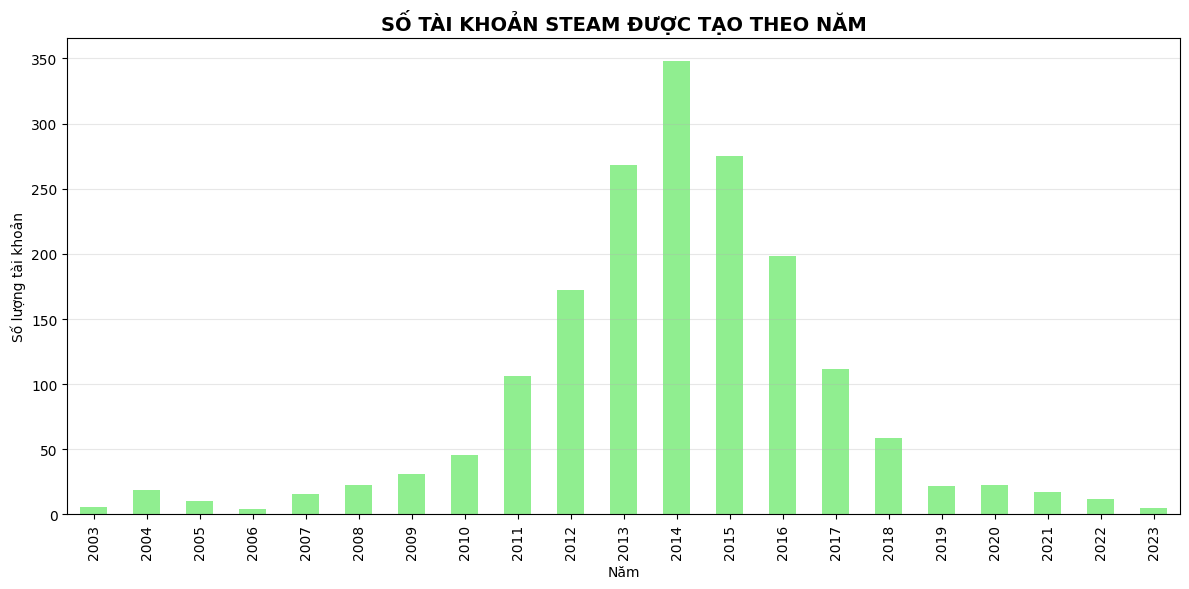

In [12]:
# 5. PH√ÇN T√çCH TH·ªúI GIAN (CH·ªà CHO USER C√ì TIMECREATED)

print("\n PH√ÇN T√çCH TU·ªîI T√ÄI KHO·∫¢N ")

users_with_timecreated = df[df['timecreated'].notna()]

if len(users_with_timecreated) > 0:
    # Ph√¢n b·ªë theo nƒÉm
    users_with_timecreated['year_created'] = users_with_timecreated['account_created'].dt.year
    yearly_creation = users_with_timecreated['year_created'].value_counts().sort_index()
    
    print(" S·ªê T√ÄI KHO·∫¢N ƒê∆Ø·ª¢C T·∫†O THEO NƒÇM:")
    for year, count in yearly_creation.items():
        print(f"  {year}: {count} t√†i kho·∫£n")
    
    # Th·ªëng k√™ tu·ªïi t√†i kho·∫£n
    print(f"\n TH·ªêNG K√ä :")
    print(f"  ‚Ä¢ Tu·ªïi trung b√¨nh: {users_with_timecreated['account_age_days'].mean():.0f} ng√†y (~{users_with_timecreated['account_age_days'].mean()/365:.1f} nƒÉm)")
    print(f"  ‚Ä¢ Tu·ªïi trung v·ªã: {users_with_timecreated['account_age_days'].median():.0f} ng√†y")
    print(f"  ‚Ä¢ T√†i kho·∫£n c≈© nh·∫•t: {users_with_timecreated['account_age_days'].max():.0f} ng√†y (~{users_with_timecreated['account_age_days'].max()/365:.1f} nƒÉm)")
    print(f"  ‚Ä¢ T√†i kho·∫£n m·ªõi nh·∫•t: {users_with_timecreated['account_age_days'].min():.0f} ng√†y (~{users_with_timecreated['account_age_days'].min()/365:.1f} nƒÉm)")
    
    # Bi·ªÉu ƒë·ªì nƒÉm t·∫°o t√†i kho·∫£n
    plt.figure(figsize=(12, 6))
    yearly_creation.plot(kind='bar', color='lightgreen')
    plt.title('S·ªê T√ÄI KHO·∫¢N STEAM ƒê∆Ø·ª¢C T·∫†O THEO NƒÇM', fontsize=14, fontweight='bold')
    plt.xlabel('NƒÉm')
    plt.ylabel('S·ªë l∆∞·ª£ng t√†i kho·∫£n')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

In [14]:

# 3. PH√ÇN T√çCH T·ªîNG QUAN
print("PH√ÇN T√çCH T·ªîNG QUAN - 1949 USER STEAM")
# Th·ªëng k√™ c∆° b·∫£n
has_realname = df['realname'].notna().sum()
has_country = df['loccountrycode'].notna().sum()

print(f" TH·ªêNG K√ä PROFILE:")
print(f"‚Ä¢ C√≥ t√™n th·∫≠t: {has_realname}/{len(df)} ({has_realname/len(df)*100:.1f}%)")
print(f"‚Ä¢ C√≥ qu·ªëc gia: {has_country}/{len(df)} ({has_country/len(df)*100:.1f}%)")
print(f"‚Ä¢ C√≥ timecreated: {df['timecreated'].notna().sum()}/{len(df)} ({(df['timecreated'].notna().sum()/len(df))*100:.1f}%)")


    


PH√ÇN T√çCH T·ªîNG QUAN - 1949 USER STEAM
 TH·ªêNG K√ä PROFILE:
‚Ä¢ C√≥ t√™n th·∫≠t: 910/1949 (46.7%)
‚Ä¢ C√≥ qu·ªëc gia: 1349/1949 (69.2%)
‚Ä¢ C√≥ timecreated: 1772/1949 (90.9%)



PH√ÇN T√çCH ƒê·ªäA L√ù NG∆Ø·ªúI D√ôNG
üè¥‚Äç‚ò†Ô∏è TOP 10 QU·ªêC GIA:
  VN: 632 users (46.8%)
  US: 111 users (8.2%)
  JP: 51 users (3.8%)
  GB: 46 users (3.4%)
  DE: 42 users (3.1%)
  RU: 33 users (2.4%)
  FR: 31 users (2.3%)
  CA: 28 users (2.1%)
  CN: 22 users (1.6%)
  KR: 20 users (1.5%)


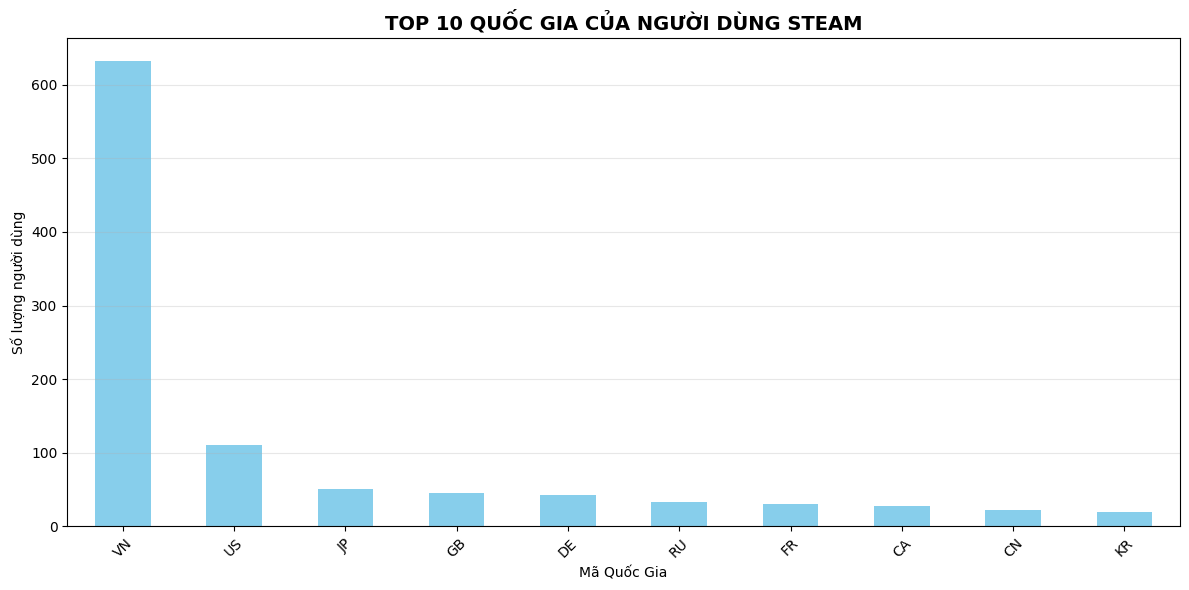

In [15]:
# 4. PH√ÇN T√çCH ƒê·ªäA L√ù
print("\n" + "="*60)
print("PH√ÇN T√çCH ƒê·ªäA L√ù NG∆Ø·ªúI D√ôNG")
print("="*60)

if has_country > 0:
    country_stats = df['loccountrycode'].value_counts().head(10)
    print(" TOP 10 QU·ªêC GIA:")
    for country, count in country_stats.items():
        percentage = (count / has_country) * 100
        print(f"  {country}: {count} users ({percentage:.1f}%)")
    
    # Bi·ªÉu ƒë·ªì qu·ªëc gia
    plt.figure(figsize=(12, 6))
    country_stats.head(10).plot(kind='bar', color='skyblue')
    plt.title('TOP 10 QU·ªêC GIA C·ª¶A NG∆Ø·ªúI D√ôNG STEAM', fontsize=14, fontweight='bold')
    plt.xlabel('M√£ Qu·ªëc Gia')
    plt.ylabel('S·ªë l∆∞·ª£ng ng∆∞·ªùi d√πng')
    plt.xticks(rotation=45)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print(" L√¥ÃÉi ")



In [16]:
# 3. PH√ÇN T√çKH KH√ÅM PH√Å (EDA) - TR·∫¢ L·ªúI C√ÇU H·ªéI C∆† B·∫¢N

print("PH√ÇN T√çCH T·ªîNG QUAN")
# Ph√¢n b·ªë tr·∫°ng th√°i online
print("\nPH√ÇN B·ªê TR·∫†NG TH√ÅI ONLINE:")
print(df['personastate'].value_counts())









PH√ÇN T√çCH T·ªîNG QUAN

PH√ÇN B·ªê TR·∫†NG TH√ÅI ONLINE:
personastate
0.0    1771
1.0      92
3.0      36
4.0      22
Name: count, dtype: int64
